# Dallas Animal Shelter 2019

Data is from 2 separate Dallas Animal Shelter records: one contains data from October 2018-September 2019 and the other from October 2019-March 2020.

This analysis will simply look year 2019, taking all data within 2019 from both datasets into one.

## Hypothesis Testing  

**Null Hypothesis**: There are no differences between the adoption percentage of cats and dogs.

**Alternative Hypothesis**: There are differences between the adoption percentage of cats and dogs.


## Load in data

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 50)

plt.style.use('ggplot')

%matplotlib inline

# description of fields: https://www.dallasopendata.com/City-Services/Animals-Inventory/qgg6-h4bd
# https://gis.dallascityhall.com/documents/StaticMaps/Council/2013_Council_PDFs/2013_CouncilDistrictAllA.pdf

In [2]:
fy_2020 = pd.read_csv('FY2020_Dallas_Animal_Shelter_Data.csv', low_memory=False)
fy_2019 = pd.read_csv('FY_2019_Dallas_Animal_Shelter_Data.csv', low_memory=False)

_Check months to make sure it has all of 2019 months that are missing in the 2020 dataset._

In [3]:
fy_2020['Month'].value_counts()

OCT.2019    3998
JAN.2020    3658
NOV.2019    3526
DEC.2019    3363
FEB.2020    3127
MAR.2020    2575
Name: Month, dtype: int64

In [4]:
fy_2019['Month'].value_counts()

JUN.2019    4953
MAY.2019    4658
JUL.2019    4539
AUG.2019    4239
SEP.2019    3928
JAN.2019    3843
APR.2019    3759
MAR.2019    3681
DEC.2018    3523
OCT.2018    3219
FEB.2019    3093
NOV.2018    2974
Name: Month, dtype: int64

In [5]:
print(fy_2020.shape)
print(fy_2019.shape)

(20247, 34)
(46409, 34)


_Checking to make sure the column names match so they can be merged correctly._

In [6]:
print('FY2020 Column Names: ', fy_2020.columns)
print('FY2019 Column Names: ', fy_2019.columns)

FY2020 Column Names:  Index(['Animal Id', 'Animal Type', 'Animal Breed', 'Kennel Number',
       'Kennel Status', 'Tag Type', 'Activity Number', 'Activity Sequence',
       'Source Id', 'Census Tract', 'Council District', 'Intake Type',
       'Intake Subtype', 'Intake Total', 'Reason', 'Staff Id', 'Intake Date',
       'Intake Time', 'Due Out', 'Intake Condition', 'Hold Request',
       'Outcome Type', 'Outcome Subtype', 'Outcome Date', 'Outcome Time',
       'Receipt Number', 'Impound Number', 'Service Request Number',
       'Outcome Condition', 'Chip Status', 'Animal Origin',
       'Additional Information', 'Month', 'Year'],
      dtype='object')
FY2019 Column Names:  Index(['Animal_Id', 'Animal_Type', 'Animal_Breed', 'Kennel_Number',
       'Kennel_Status', 'Tag_Type', 'Activity_Number', 'Activity_Sequence',
       'Source_Id', 'Census_Tract', 'Council_District', 'Intake_Type',
       'Intake_Subtype', 'Intake_Total', 'Reason', 'Staff_Id', 'Intake_Date',
       'Intake_Time', 'Du

_It looks like 2019 dataset columns have an underscore instead spaces. Let's change it all to the standard python snake case with underscore as spaces._

In [7]:
fy_2020.columns = fy_2020.columns.str.strip().str.lower().str.replace(' ', '_')
fy_2019.columns = fy_2019.columns.str.strip().str.lower()

## Time and Date

_Checking the date and time columns to make sure the formats are similar because it will need to be combined later on._

In [8]:
fy_2020[['intake_date', 'intake_time', 'outcome_date', 'outcome_time']].head()

,intake_date,intake_time,outcome_date,outcome_time
0,11/8/19,15:48:00,11/9/19,11:31:00
1,11/10/19,14:18:00,11/10/19,0:00:00
2,10/3/19,11:08:00,10/3/19,13:36:00
3,10/11/19,9:55:00,10/15/19,17:35:00
4,11/8/19,11:55:00,11/9/19,12:57:00


_The 2020 date and time column looks good._

In [9]:
fy_2019[['intake_date', 'intake_time', 'outcome_date', 'outcome_time']].head()

,intake_date,intake_time,outcome_date,outcome_time
0,03/03/2019 12:00:00 AM,16:00:00,03/03/2019 12:00:00 AM,16:03:00
1,10/03/2018 12:00:00 AM,22:04:00,10/12/2018 12:00:00 AM,12:21:00
2,01/26/2019 12:00:00 AM,13:21:00,01/26/2019 12:00:00 AM,17:06:00
3,06/08/2019 12:00:00 AM,14:29:00,06/08/2019 12:00:00 AM,14:29:00
4,12/31/2018 12:00:00 AM,12:51:00,12/31/2018 12:00:00 AM,13:12:00


_The time inside the date column is unnecessary and will only cause trouble later on. It will be stripped._

In [10]:
#The intake_date column does not contain any null values and the outcome_date column contains 6.
print(fy_2019[fy_2019['intake_date'].str.contains('12:00:00 AM')].shape)
print(fy_2019[fy_2019['outcome_date'].isnull()].shape)

(46409, 34)
(6, 34)


In [11]:
fy_2019['intake_date'] = fy_2019['intake_date'].str.replace(' 12:00:00 AM', '')
fy_2019['outcome_date'] = fy_2019['outcome_date'].str.replace(' 12:00:00 AM', '')
print(fy_2019[['intake_date','outcome_date']].head(1))

  intake_date outcome_date
0  03/03/2019   03/03/2019


_In order to exact information such as day, month, and so on, the datetime columns need to be converted to DateTime objects._

In [12]:
fy_2019['intake_datetime'] = fy_2019['intake_date'] + ' ' + fy_2019['intake_time']
fy_2019['outcome_datetime'] = fy_2019['outcome_date'] + ' ' + fy_2019['outcome_time']
fy_2019['intake_datetime'] = pd.to_datetime(fy_2019['intake_datetime'], format='%m/%d/%Y %H:%M:%S')
fy_2019['outcome_datetime'] = pd.to_datetime(fy_2019['outcome_datetime'], format='%m/%d/%Y %H:%M:%S')

fy_2020['intake_datetime'] = fy_2020['intake_date'] + ' ' + fy_2020['intake_time']
fy_2020['outcome_datetime'] = fy_2020['outcome_date'] + ' ' + fy_2020['outcome_time']
fy_2020['intake_datetime'] = pd.to_datetime(fy_2020['intake_datetime'], format='%m/%d/%y %H:%M:%S')
fy_2020['outcome_datetime'] = pd.to_datetime(fy_2020['outcome_datetime'], format='%m/%d/%y %H:%M:%S')

In [13]:
print(fy_2019[['intake_datetime', 'outcome_datetime']].head(1))
print('\n')
print(fy_2020[['intake_datetime', 'outcome_datetime']].head(1))

      intake_datetime    outcome_datetime
0 2019-03-03 16:00:00 2019-03-03 16:03:00


      intake_datetime    outcome_datetime
0 2019-11-08 15:48:00 2019-11-09 11:31:00


## Merge datasets

In [14]:
original_df = pd.concat([fy_2020, fy_2019], axis=0, join='outer')
original_df.head()

,animal_id,animal_type,animal_breed,kennel_number,kennel_status,tag_type,activity_number,activity_sequence,source_id,census_tract,council_district,intake_type,intake_subtype,intake_total,reason,staff_id,intake_date,intake_time,due_out,intake_condition,hold_request,outcome_type,outcome_subtype,outcome_date,outcome_time,receipt_number,impound_number,service_request_number,outcome_condition,chip_status,animal_origin,additional_information,month,year,intake_datetime,outcome_datetime
0,A0144701,DOG,HAVANESE,VT 12,IMPOUNDED,NaN,NaN,1,P0098773,6301,4,OWNER SURRENDER,GENERAL,1,PERSNLISSU,CDM,11/8/19,15:48:00,11/14/19,APP SICK,NaN,RETURNED TO OWNER,WALK IN,11/9/19,11:31:00,R19-558731,K19-486742,NaN,APP SICK,SCAN CHIP,OVER THE COUNTER,RETURNED TO OWNER,NOV.2019,FY2020,2019-11-08 15:48:00,2019-11-09 11:31:00
1,A0442587,DOG,TERRIER MIX,FREEZER,IMPOUNDED,NaN,NaN,1,P0492284,7102,2,OWNER SURRENDER,DEAD ON ARRIVAL,1,OTHRINTAKS,CDM,11/10/19,14:18:00,11/10/19,DEAD,NaN,DEAD ON ARRIVAL,DISPOSAL,11/10/19,0:00:00,NaN,K19-486954,NaN,DEAD,SCAN CHIP,OVER THE COUNTER,NaN,NOV.2019,FY2020,2019-11-10 14:18:00,2019-11-10 00:00:00
2,A0458972,DOG,CATAHOULA,RECEIVING,UNAVAILABLE,NaN,A19-195601,1,P9991718,4600,1,STRAY,AT LARGE,1,OTHER,MG1718,10/3/19,11:08:00,10/3/19,TREATABLE REHABILITABLE NON-CONTAGIOUS,NaN,RETURNED TO OWNER,FIELD,10/3/19,13:36:00,NaN,K19-482022,NaN,TREATABLE REHABILITABLE NON-CONTAGIOUS,SCAN NO CHIP,SWEEP,NaN,OCT.2019,FY2020,2019-10-03 11:08:00,2019-10-03 13:36:00
3,A0525642,DOG,GERM SHEPHERD,INJD 001,IMPOUNDED,NaN,A19-196573,1,P0903792,16605,8,OWNER SURRENDER,GENERAL,1,OTHER,RA 1549,10/11/19,9:55:00,10/17/19,TREATABLE REHABILITABLE NON-CONTAGIOUS,EMERGENCY RESCUE,TRANSFER,MEDICAL-CONTAGIOUS,10/15/19,17:35:00,NaN,K19-483073,NaN,TREATABLE REHABILITABLE NON-CONTAGIOUS,SCAN CHIP,SWEEP,TAGGED,OCT.2019,FY2020,2019-10-11 09:55:00,2019-10-15 17:35:00
4,A0565586,DOG,SILKY TERRIER,LFD 119,UNAVAILABLE,NaN,NaN,1,P0890077,6900,1,STRAY,AT LARGE,1,OTHRINTAKS,JR,11/8/19,11:55:00,11/14/19,APP WNL,RESCU ONLY,RETURNED TO OWNER,WALK IN,11/9/19,12:57:00,R19-558750,K19-486694,NaN,APP WNL,SCAN CHIP,OVER THE COUNTER,RETURNED TO OWNER,NOV.2019,FY2020,2019-11-08 11:55:00,2019-11-09 12:57:00


In [15]:
original_df = original_df[original_df['year']=='FY2019']

_Looked at value counts of many columns to determine which ones are necessary._

## Create dataframe with necessary columns

In [16]:
dallas = original_df[['animal_id', 'animal_type', 'animal_breed', 'council_district', 'intake_type', 'intake_subtype', 
                      'intake_condition', 'intake_datetime', 'reason', 'outcome_type', 
                      'outcome_subtype', 'outcome_condition', 'outcome_datetime']]

In [17]:
dallas.head()

,animal_id,animal_type,animal_breed,council_district,intake_type,intake_subtype,intake_condition,intake_datetime,reason,outcome_type,outcome_subtype,outcome_condition,outcome_datetime
0,A0002585,DOG,GERM SHEPHERD,8,STRAY,AT LARGE,TREATABLE REHABILITABLE NON-CONTAGIOUS,2019-03-03 16:00:00,NaN,RETURNED TO OWNER,FIELD,TREATABLE REHABILITABLE NON-CONTAGIOUS,2019-03-03 16:03:00
1,A0014639,DOG,PIT BULL,7,STRAY,AT LARGE,TREATABLE REHABILITABLE NON-CONTAGIOUS,2018-10-03 22:04:00,NaN,TRANSFER,OTHER,TREATABLE REHABILITABLE NON-CONTAGIOUS,2018-10-12 12:21:00
2,A0100167,DOG,CHIHUAHUA SH,1,OWNER SURRENDER,EUTHANASIA REQUESTED,TREATABLE REHABILITABLE NON-CONTAGIOUS,2019-01-26 13:21:00,TOO OLD,EUTHANIZED,MEDICAL-NONCONTAGIOUS,UNHEALTHY UNTREATABLE NON-CONTAGIOUS,2019-01-26 17:06:00
3,A0112749,DOG,PIT BULL,1,STRAY,AT LARGE,TREATABLE REHABILITABLE NON-CONTAGIOUS,2019-06-08 14:29:00,OTHER,RETURNED TO OWNER,FIELD,TREATABLE REHABILITABLE NON-CONTAGIOUS,2019-06-08 14:29:00
4,A0154626,CAT,DOMESTIC SH,1,OWNER SURRENDER,GENERAL,TREATABLE REHABILITABLE NON-CONTAGIOUS,2018-12-31 12:51:00,ILL,EUTHANIZED,HUMANE,UNHEALTHY UNTREATABLE NON-CONTAGIOUS,2018-12-31 13:12:00


## Missing values and strange datatypes

In [18]:
dallas.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46409 entries, 0 to 46408
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   animal_id          46409 non-null  object        
 1   animal_type        46409 non-null  object        
 2   animal_breed       46409 non-null  object        
 3   council_district   45252 non-null  object        
 4   intake_type        46409 non-null  object        
 5   intake_subtype     46409 non-null  object        
 6   intake_condition   46409 non-null  object        
 7   intake_datetime    46409 non-null  datetime64[ns]
 8   reason             26111 non-null  object        
 9   outcome_type       46409 non-null  object        
 10  outcome_subtype    46409 non-null  object        
 11  outcome_condition  44954 non-null  object        
 12  outcome_datetime   46403 non-null  datetime64[ns]
dtypes: datetime64[ns](2), object(11)
memory usage: 5.0+ MB


_Every column seems to have minimal amounts of missing values except for the 'reason' column. We will check the values within that column and see if it is important._

In [19]:
dallas['reason'].unique()

array([nan, 'TOO OLD', 'OTHER', 'ILL', 'OTHRINTAKS', 'MEDICAL',
       'EUTHANASIA ILL', 'PERSNLISSU', 'LANDLORD', 'NOTRIGHTFT', 'COST',
       'DEAD ON ARRIVAL', 'QUARANTINE', 'OWNER DIED', 'HOUSING',
       'NO HOME', 'FINANCIAL', 'AGGRESSIVE - ANIMAL', 'MOVE', 'BEHAVIOR',
       'OTHER PET', 'ALLERGIC', 'VOCAL', 'RESPONSIBLE', 'MOVE APT',
       'NO TIME', 'NO YARD', 'OWNER PROBLEM', 'DESTRUCTIVE OUTSIDE',
       'BLIND', 'AGGRESSIVE - PEOPLE', 'ESCAPES', 'BITES', 'FOSTER',
       'DESTRUCTIVE AT HOME', 'CAUTIONCAT', 'HYPER', 'INJURED', 'ABANDON',
       'CHILD PROBLEM', 'ATTENTION', 'TRAVEL', 'DISOBIDIEN', 'FOUND ANIM',
       'NEW BABY', 'TOO BIG', 'NOFRIENDLY', 'JUMPS UP', 'TOO MANY',
       'GIFT', 'HOUSE SOIL', 'RETURN', 'AFRAID', 'WONT ALLOW', 'UNKNOWN',
       'PET LIMITS', 'STRAY', 'FENCE', 'CONFISCATE', 'WILDLIFE',
       'WANTS OUT', 'KILLED ANOTHER ANIMAL', 'EUTHANASIA OTHER',
       'TOO YOUNG', 'CHASES PEOPLE', 'WRONG SEX', 'EUTHANASIA OLD',
       'EUTHANASIA BEHAV', '

_Most of the reasons are similar but different and very specific. It will not be too useful for this hypothesis since we are looking at simply the intake condition and the general intake type. Checking out the value counts, they are also mainly in the 'other' category will small amounts in the other categories. We can safely drop the 'reason' column entirely._

In [20]:
pd.options.mode.chained_assignment = None

dallas.drop(['reason'], axis=1, inplace=True)

In [21]:
# check to make sure 'reason' column got dropped
dallas.columns

Index(['animal_id', 'animal_type', 'animal_breed', 'council_district',
       'intake_type', 'intake_subtype', 'intake_condition', 'intake_datetime',
       'outcome_type', 'outcome_subtype', 'outcome_condition',
       'outcome_datetime'],
      dtype='object')

_The rest of the columns do not contain a huge amount of missing values that would affect the testing. Therefore, we will drop all rows with null values._

In [22]:
dallas.dropna(axis=0, inplace=True)

In [23]:
dallas.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44949 entries, 0 to 46408
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   animal_id          44949 non-null  object        
 1   animal_type        44949 non-null  object        
 2   animal_breed       44949 non-null  object        
 3   council_district   44949 non-null  object        
 4   intake_type        44949 non-null  object        
 5   intake_subtype     44949 non-null  object        
 6   intake_condition   44949 non-null  object        
 7   intake_datetime    44949 non-null  datetime64[ns]
 8   outcome_type       44949 non-null  object        
 9   outcome_subtype    44949 non-null  object        
 10  outcome_condition  44949 non-null  object        
 11  outcome_datetime   44949 non-null  datetime64[ns]
dtypes: datetime64[ns](2), object(10)
memory usage: 4.5+ MB


In [24]:
dallas['council_district'].value_counts(dropna=False)

6.0     9277
4.0     6000
8.0     5540
5.0     4893
7.0     3938
1.0     3809
3.0     3195
2.0     2357
9.0     1565
10.0    1134
14.0     831
12.0     823
11.0     802
13.0     782
21.0       2
0.0        1
Name: council_district, dtype: int64

_The council district is a bit messy. It has multiple datatypes but are basically the same number. The numbers will have to be changed to integer type and drop the random string value.  
Also, looking at the Dallas district map, there are no districts 0 or 21. Those rows will also be dropped._

In [25]:
#Taking only rows where council_district is not the string value thus dropping those rows.
dallas = dallas[(dallas['council_district'] != 'AS')]

In [26]:
#Mapping the int() function on all values to change the datatype
dallas['council_district'] = dallas['council_district'].map(int)

In [27]:
#Dropping all the district 0's and 21's
dallas.drop(dallas[dallas['council_district'] == 0].index, inplace=True)
dallas.drop(dallas[dallas['council_district'] == 21].index, inplace=True)

In [28]:
dallas['council_district'].value_counts().sort_index()

1     3809
2     2357
3     3195
4     6000
5     4893
6     9277
7     3938
8     5540
9     1565
10    1134
11     802
12     823
13     782
14     831
Name: council_district, dtype: int64

### Datatypes

In [29]:
dallas.dtypes

animal_id                    object
animal_type                  object
animal_breed                 object
council_district              int64
intake_type                  object
intake_subtype               object
intake_condition             object
intake_datetime      datetime64[ns]
outcome_type                 object
outcome_subtype              object
outcome_condition            object
outcome_datetime     datetime64[ns]
dtype: object

_animal id should be an integer type but it contains an 'A' in front. It will need to be stripped and convert to int._

In [30]:
dallas['animal_id'] = dallas['animal_id'].str.strip('A')
dallas['animal_id'].head()

0    0002585
1    0014639
2    0100167
3    0112749
4    0154626
Name: animal_id, dtype: object

In [31]:
dallas['animal_id'] = dallas['animal_id'].astype('int')
dallas['animal_id'].head()

0      2585
1     14639
2    100167
3    112749
4    154626
Name: animal_id, dtype: int64

### Reset Index

In [32]:
#Check index duplicates
dallas[dallas.index.duplicated()].count()

animal_id            0
animal_type          0
animal_breed         0
council_district     0
intake_type          0
intake_subtype       0
intake_condition     0
intake_datetime      0
outcome_type         0
outcome_subtype      0
outcome_condition    0
outcome_datetime     0
dtype: int64

In [33]:
dallas[dallas.index == 1207]

,animal_id,animal_type,animal_breed,council_district,intake_type,intake_subtype,intake_condition,intake_datetime,outcome_type,outcome_subtype,outcome_condition,outcome_datetime
1207,955803,CAT,DOMESTIC SH,11,OWNER SURRENDER,GENERAL,TREATABLE REHABILITABLE NON-CONTAGIOUS,2019-06-28 11:49:00,ADOPTION,EAC,HEALTHY,2019-07-17 17:02:00


_There appears to be duplicate indexes in the dataframe even though the animal id is different. It will need to be reset to 0 to the length of the dataframe._

In [34]:
dallas.index = np.arange(len(dallas))

In [35]:
dallas[dallas.index.duplicated()].count()

animal_id            0
animal_type          0
animal_breed         0
council_district     0
intake_type          0
intake_subtype       0
intake_condition     0
intake_datetime      0
outcome_type         0
outcome_subtype      0
outcome_condition    0
outcome_datetime     0
dtype: int64

# Exploratory Data Analysis (EDA)

In [36]:
#Plotting helper functions

def autolabel(bar_graph, ax):
    for bar in bar_graph:
        height = bar.get_height()
        ax.annotate(f'{height}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

def bar_count(ax, cat_col, dog_col, width=0.35):
    axes_labels = cat_col.index
    x = np.arange(len(axes_labels))
    cat = ax.bar(x - width/2, cat_col, width, label='Cats', color='tomato')
    dog = ax.bar(x + width/2, dog_col, width, label='Dogs', color='lightseagreen')
    ax.set_ylabel('Counts')
    ax.set_title(f'Count of {cat_col.name}: Cats vs Dogs')
    ax.set_xticks(x)
    ax.set_xticklabels(axes_labels, rotation=45)
    ax.legend(loc='upper center')
    autolabel(cat, ax)
    autolabel(dog, ax)
    
def bar_percent(ax, cat_col, dog_col, width=0.35):
    cats_data = cat_col.values
    cats_percent = ((cats_data / cats_data.sum()) * 100).round()
    dogs_data = dog_col.values
    dogs_percent = ((dogs_data / dogs_data.sum()) * 100).round()
    
    axes_labels = cat_col.index
    x = np.arange(len(axes_labels))
    cat = ax.bar(x - width/2, cats_percent, width, label='Cats', color='tomato')
    dog = ax.bar(x + width/2, dogs_percent, width, label='Dogs', color='lightseagreen')
    ax.set_ylabel('Percentage')
    ax.set_title(f'Percentage of {cat_col.name}: Cats vs Dogs')
    ax.set_xticks(x)
    ax.set_xticklabels(axes_labels, rotation=45)
    ax.legend(loc='upper center')
    autolabel(cat, ax)
    autolabel(dog, ax)

## Column Values

In [37]:
dallas.head()

,animal_id,animal_type,animal_breed,council_district,intake_type,intake_subtype,intake_condition,intake_datetime,outcome_type,outcome_subtype,outcome_condition,outcome_datetime
0,2585,DOG,GERM SHEPHERD,8,STRAY,AT LARGE,TREATABLE REHABILITABLE NON-CONTAGIOUS,2019-03-03 16:00:00,RETURNED TO OWNER,FIELD,TREATABLE REHABILITABLE NON-CONTAGIOUS,2019-03-03 16:03:00
1,14639,DOG,PIT BULL,7,STRAY,AT LARGE,TREATABLE REHABILITABLE NON-CONTAGIOUS,2018-10-03 22:04:00,TRANSFER,OTHER,TREATABLE REHABILITABLE NON-CONTAGIOUS,2018-10-12 12:21:00
2,100167,DOG,CHIHUAHUA SH,1,OWNER SURRENDER,EUTHANASIA REQUESTED,TREATABLE REHABILITABLE NON-CONTAGIOUS,2019-01-26 13:21:00,EUTHANIZED,MEDICAL-NONCONTAGIOUS,UNHEALTHY UNTREATABLE NON-CONTAGIOUS,2019-01-26 17:06:00
3,112749,DOG,PIT BULL,1,STRAY,AT LARGE,TREATABLE REHABILITABLE NON-CONTAGIOUS,2019-06-08 14:29:00,RETURNED TO OWNER,FIELD,TREATABLE REHABILITABLE NON-CONTAGIOUS,2019-06-08 14:29:00
4,154626,CAT,DOMESTIC SH,1,OWNER SURRENDER,GENERAL,TREATABLE REHABILITABLE NON-CONTAGIOUS,2018-12-31 12:51:00,EUTHANIZED,HUMANE,UNHEALTHY UNTREATABLE NON-CONTAGIOUS,2018-12-31 13:12:00


In [38]:
dallas.shape

(44946, 12)

#### Animal ID

In [39]:
# Check the animal ids for any duplicates
dallas['animal_id'].nunique()

36714

In [40]:
#Testing to see how many ids have more than one count
(dallas['animal_id'].value_counts()).head(8750)

1055371    12
1070239    10
1072842     9
1057771     9
1020975     8
           ..
1082203     1
1080494     1
1071968     1
1069921     1
1067874     1
Name: animal_id, Length: 8750, dtype: int64

In [41]:
#Keep the most recent entries
dallas.drop_duplicates('animal_id', keep='last', inplace=True)

In [42]:
#Check if any animal ids still have multiple counts.
(dallas['animal_id'].value_counts() > 1).any()

False

In [43]:
dallas['animal_type'].value_counts()

DOG          26314
CAT           8896
WILDLIFE      1114
BIRD           369
LIVESTOCK       21
Name: animal_type, dtype: int64

_For the hypothesis, the only data we need are cats and dogs. The dataframe will be filtered to have only rows where the animal type is either cats or dogs._

In [44]:
dallas = dallas[(dallas['animal_type'] == 'CAT') | (dallas['animal_type'] == 'DOG')]
dallas['animal_type'].value_counts()

DOG    26314
CAT     8896
Name: animal_type, dtype: int64

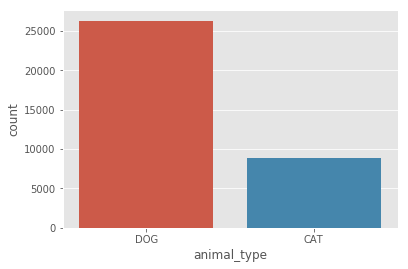

In [45]:
#Plot counts
sns.countplot(x=dallas['animal_type'])
plt.savefig('animal_type_count.png')

In [46]:
print('Intake Type: ', list(dallas['intake_type'].unique()))
print('\n')
print('Intake Subtype: ', list(dallas['intake_subtype'].unique()))
print('\n')
print('Intake Condition: ', list(dallas['intake_condition'].unique()))
print('\n')
print('Outcome Type: ', list(dallas['outcome_type'].unique()))
print('\n')
print('Outcome Subtype: ', list(dallas['outcome_subtype'].unique()))
print('\n')
print('Outcome Condition: ', list(dallas['outcome_condition'].unique()))

Intake Type:  ['STRAY', 'OWNER SURRENDER', 'CONFISCATED', 'TRANSFER', 'TREATMENT', 'FOSTER']


Intake Subtype:  ['AT LARGE', 'EUTHANASIA REQUESTED', 'GENERAL', 'POSSIBLY OWNED', 'QUARANTINE', 'KEEP SAFE', 'OTHER', 'CONFINED', 'DEAD ON ARRIVAL', 'HEART WORM', 'TRAP PROGRAM', 'DANGEROUS', 'RETURN30', 'CRUELTY', 'TREATMENT', 'RETURN', 'EVICTION', 'QUARANTINE DEAD ON ARRIVAL', 'DIED', 'APPOINT', 'MISSING', 'SURGERY', 'TRAP NEUTER RETURN', 'SPCA TEXAS', 'KEEP SAFE DEAD ON ARRIVAL', 'CRUELT DEAD ON ARRIVAL', 'STRAY', 'SX POST OP', 'SAC DEAD ON ARRIVAL', 'FOR ADOPT', 'FOLLOWUP']


Intake Condition:  ['TREATABLE REHABILITABLE NON-CONTAGIOUS', 'TREATABLE MANAGEABLE NON-CONTAGIOUS', 'UNHEALTHY UNTREATABLE NON-CONTAGIOUS', 'UNHEALTHY UNTREATABLE CONTAGIOUS', 'HEALTHY', 'APP WNL', 'TREATABLE MANAGEABLE CONTAGIOUS', 'TREATABLE REHABILITABLE CONTAGIOUS', 'UNKNOWN', 'DEAD', 'APP INJ']


Outcome Type:  ['RETURNED TO OWNER', 'TRANSFER', 'EUTHANIZED', 'ADOPTION', 'DEAD ON ARRIVAL', 'DIED', 'TREATMENT', 

In [47]:
dallas['intake_type'].value_counts()

STRAY              23559
OWNER SURRENDER     8039
FOSTER              1703
CONFISCATED         1408
TREATMENT            316
TRANSFER             185
Name: intake_type, dtype: int64

In [48]:
dallas['outcome_type'].value_counts()

ADOPTION             11443
RETURNED TO OWNER     9694
TRANSFER              7066
EUTHANIZED            4654
FOSTER                1273
DIED                   406
DEAD ON ARRIVAL        341
TREATMENT              317
MISSING                 16
Name: outcome_type, dtype: int64

In [49]:
dallas.groupby(['outcome_type', 'outcome_subtype']).count()['intake_subtype'].head(50)

outcome_type       outcome_subtype      
ADOPTION           AD TV                       2
                   BY FOSTER                  65
                   EAC                      1018
                   EAC OFFSIT                  2
                   EVENT                      95
                   IN FOSTER                 194
                   OFFSITE                   193
                   PAY PENDNG                  7
                   PHONE                       1
                   PROMOTION                1096
                   REFERRAL                  145
                   RESCUE GROUP                1
                   WALK IN                  8618
                   WEB                         6
DEAD ON ARRIVAL    DISPOSAL                  270
                   HOLD                       50
                   RETURN                      4
                   TRANS-INV                  17
DIED               AT VETERINARIAN             8
                   ENROUTE  

In [50]:
dallas.groupby(['intake_type', 'intake_subtype']).count()['outcome_type'].head(50)

intake_type      intake_subtype            
CONFISCATED      CRUELT DEAD ON ARRIVAL           18
                 CRUELTY                          78
                 DANGEROUS                        20
                 EVICTION                         40
                 KEEP SAFE                       463
                 KEEP SAFE DEAD ON ARRIVAL        10
                 QUARANTINE                      723
                 QUARANTINE DEAD ON ARRIVAL       55
                 SAC DEAD ON ARRIVAL               1
FOSTER           APPOINT                           1
                 DIED                             71
                 FOR ADOPT                         1
                 GENERAL                         779
                 MISSING                           3
                 QUARANTINE                        7
                 RETURN                          418
                 STRAY                             3
                 SURGERY                         121
  

_Looking at the outcome type and the outcome subtype, it seems the intake subtype and outcome subtype is not really necessary. The main goal is to see if they make it to adoption stage, but it doesn't matter who does the adoption. The intake subtype and outcome subtype column will be dropped._

In [51]:
dallas.drop('outcome_subtype', axis=1, inplace=True)
# dallas.drop('intake_subtype', axis=1, inplace=True)

In [52]:
dallas.head(1)

,animal_id,animal_type,animal_breed,council_district,intake_type,intake_subtype,intake_condition,intake_datetime,outcome_type,outcome_condition,outcome_datetime
0,2585,DOG,GERM SHEPHERD,8,STRAY,AT LARGE,TREATABLE REHABILITABLE NON-CONTAGIOUS,2019-03-03 16:00:00,RETURNED TO OWNER,TREATABLE REHABILITABLE NON-CONTAGIOUS,2019-03-03 16:03:00


In [53]:
cats = dallas[dallas['animal_type'] == 'CAT']
dogs = dallas[dallas['animal_type'] == 'DOG']

In [54]:
dogs['animal_breed'].value_counts().sort_values(ascending=False).head(5)

PIT BULL         5861
CHIHUAHUA SH     3992
GERM SHEPHERD    3296
LABRADOR RETR    2994
CAIRN TERRIER     831
Name: animal_breed, dtype: int64

In [55]:
cats['animal_breed'].value_counts().sort_values(ascending=False).head(5)

DOMESTIC SH    7842
DOMESTIC MH     699
DOMESTIC LH     125
SIAMESE         108
AMER SH          48
Name: animal_breed, dtype: int64

## Percentages

cats:
- count per month intakes (intake_datetime.dt.month)
- each_intake_type/total_intake_type
- each_outcome_type/total_outcome_type
- count of month outcomes  
- type of intake and the outcome

dogs:
- count per month intakes (intake_datetime.dt.month)
- each_intake_type/total_intake_type
- each_outcome_type/total_outcome_type
- count of month outcomes
- type of intake and the outcome

In [57]:
dallas['outcome_month'] = dallas['outcome_datetime'].dt.month
dallas['intake_month'] = dallas['outcome_datetime'].dt.month
cats['outcome_month'] = cats['outcome_datetime'].dt.month
dogs['outcome_month'] = dogs['outcome_datetime'].dt.month
cats['intake_month'] = cats['intake_datetime'].dt.month
dogs['intake_month'] = dogs['intake_datetime'].dt.month
cats['day'] = cats['outcome_datetime'].dt.day
dogs['day'] = dogs['outcome_datetime'].dt.day

cats_month_out = cats['outcome_month'].value_counts().values
cats_percent_out = ((cats_month_out / cats_month_out.sum()) * 100).round()
dogs_month_out = dogs['outcome_month'].value_counts().values
dogs_percent_out = ((dogs_month_out / dogs_month_out.sum()) * 100).round()

cats_month_in = cats['intake_month'].value_counts().values
cats_percent_in = ((cats_month_in / cats_month_in.sum()) * 100).round()
dogs_month_in = dogs['intake_month'].value_counts().values
dogs_percent_in = ((dogs_month_in / dogs_month_in.sum()) * 100).round()

### Count/Percentage Intake of Cats and Dogs per Month

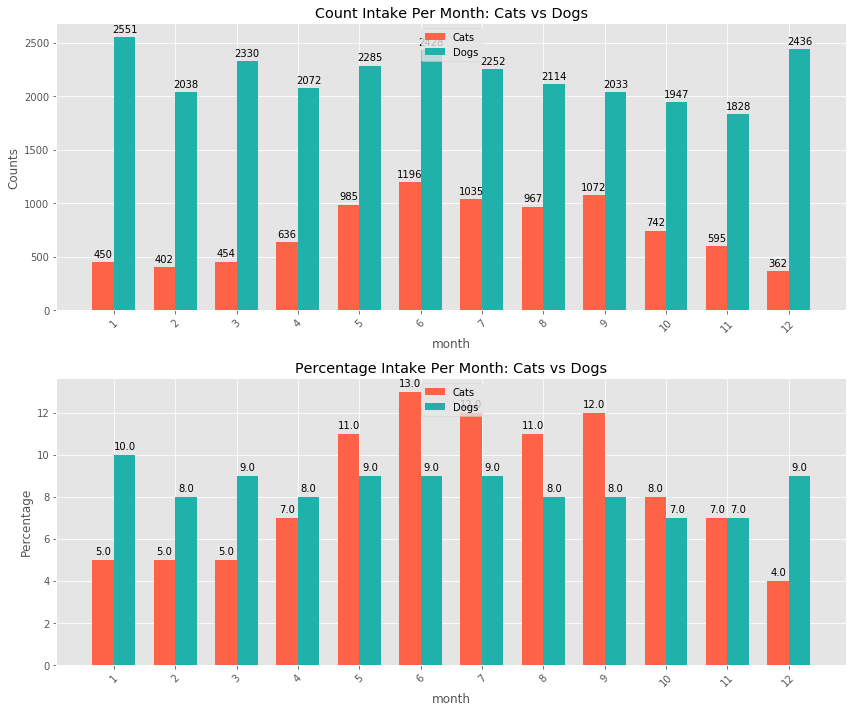

In [58]:
fig, axes = plt.subplots(2,1,figsize=(12,10))

bar_count(axes[0], cats['intake_month'].value_counts().sort_index(), 
          dogs['intake_month'].value_counts().sort_index())

bar_percent(axes[1], cats['intake_month'].value_counts().sort_index(), 
            dogs['intake_month'].value_counts().sort_index())

axes[0].set_xlabel('month')
axes[1].set_xlabel('month')

axes[0].set_title('Count Intake Per Month: Cats vs Dogs')
axes[1].set_title('Percentage Intake Per Month: Cats vs Dogs')

plt.tight_layout()

plt.savefig('count_perc_monthly.png')

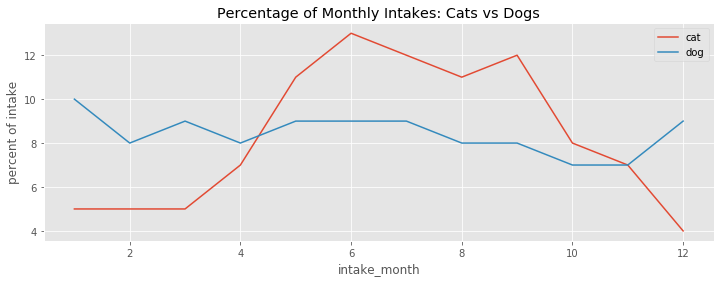

In [59]:
fig, ax = plt.subplots(figsize=(12,4))
sns.lineplot(x=cats['intake_month'].value_counts().index, y=cats_percent_in)
sns.lineplot(x=dogs['intake_month'].value_counts().index, y=dogs_percent_in)
ax.legend(labels=['cat', 'dog'])
ax.set_xlabel('intake_month')
ax.set_ylabel('percent of intake')
ax.set_title('Percentage of Monthly Intakes: Cats vs Dogs')

plt.savefig('lineplt_count_perc_monthly.png')

### Count/Percentage of Intake Type

In [77]:
# fig, axes = plt.subplots(2,1, figsize=(12,7))

# bar_count(axes[0], cats['intake_type'].value_counts(), dogs['intake_type'].value_counts())
# bar_percent(axes[1], cats['intake_type'].value_counts(), dogs['intake_type'].value_counts())

# axes[0].set_xlabel('intake_type')
# axes[1].set_xlabel('intake_type')

# plt.tight_layout()

# plt.savefig('count_intake_type.png')

### Intake Type Per Month

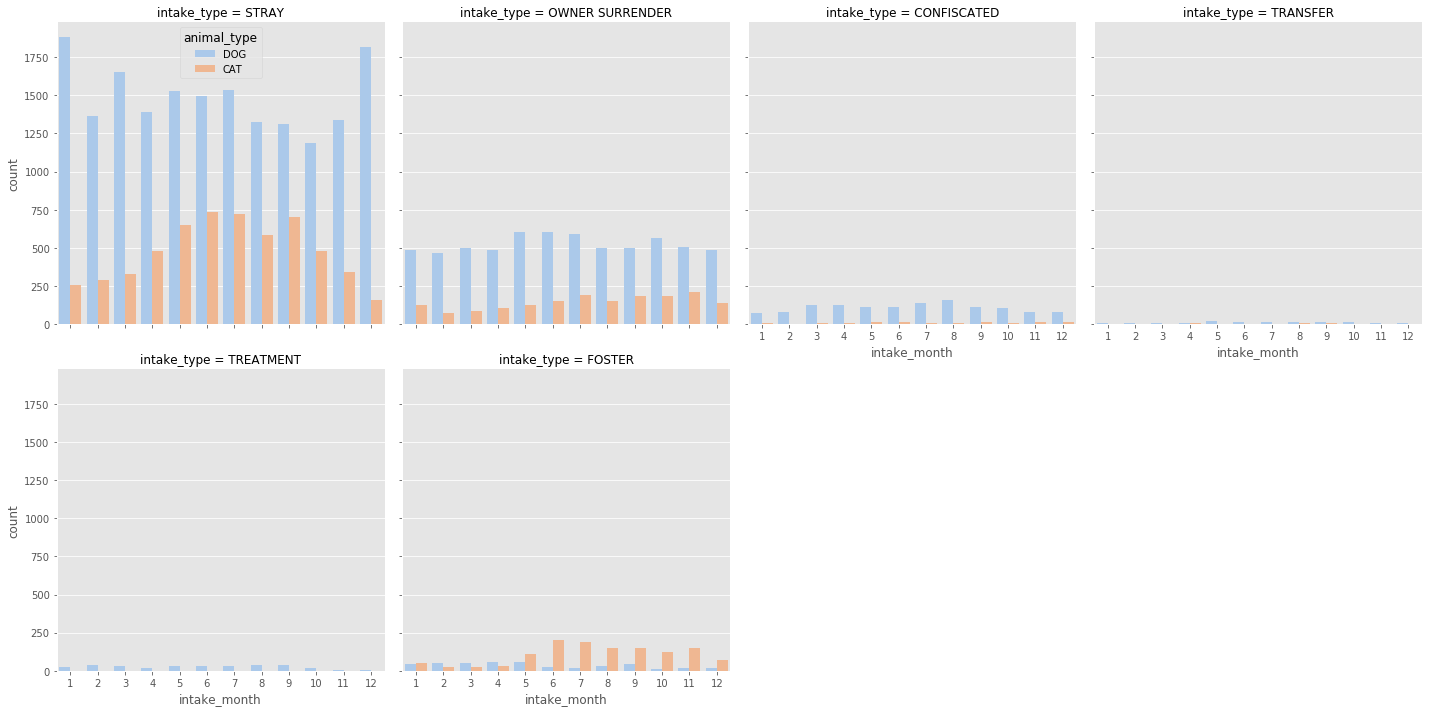

In [66]:
g = sns.catplot(x='intake_month', col="intake_type", hue='animal_type', col_wrap=4,
                data=dallas, kind="count", palette= 'pastel', legend_out=False)

plt.tight_layout()

plt.savefig('catplot_intake_type_monthly.png')

### Count/Percentage of Outcome Type

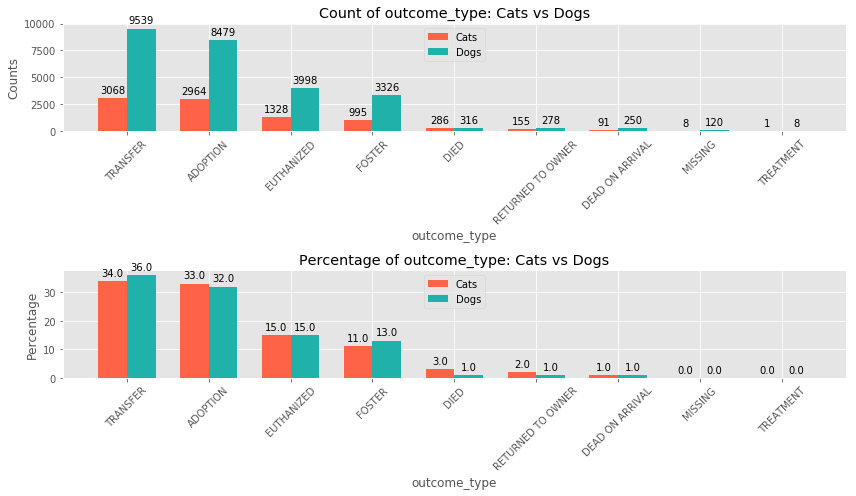

In [67]:
fig, axes = plt.subplots(2,1, figsize=(12,7))

bar_count(axes[0], cats['outcome_type'].value_counts(), dogs['outcome_type'].value_counts())
bar_percent(axes[1], cats['outcome_type'].value_counts(), dogs['outcome_type'].value_counts())

axes[0].set_xlabel('outcome_type')
axes[1].set_xlabel('outcome_type')

plt.tight_layout()

plt.savefig('count_outcome_type.png')

## Outcome Type per Month

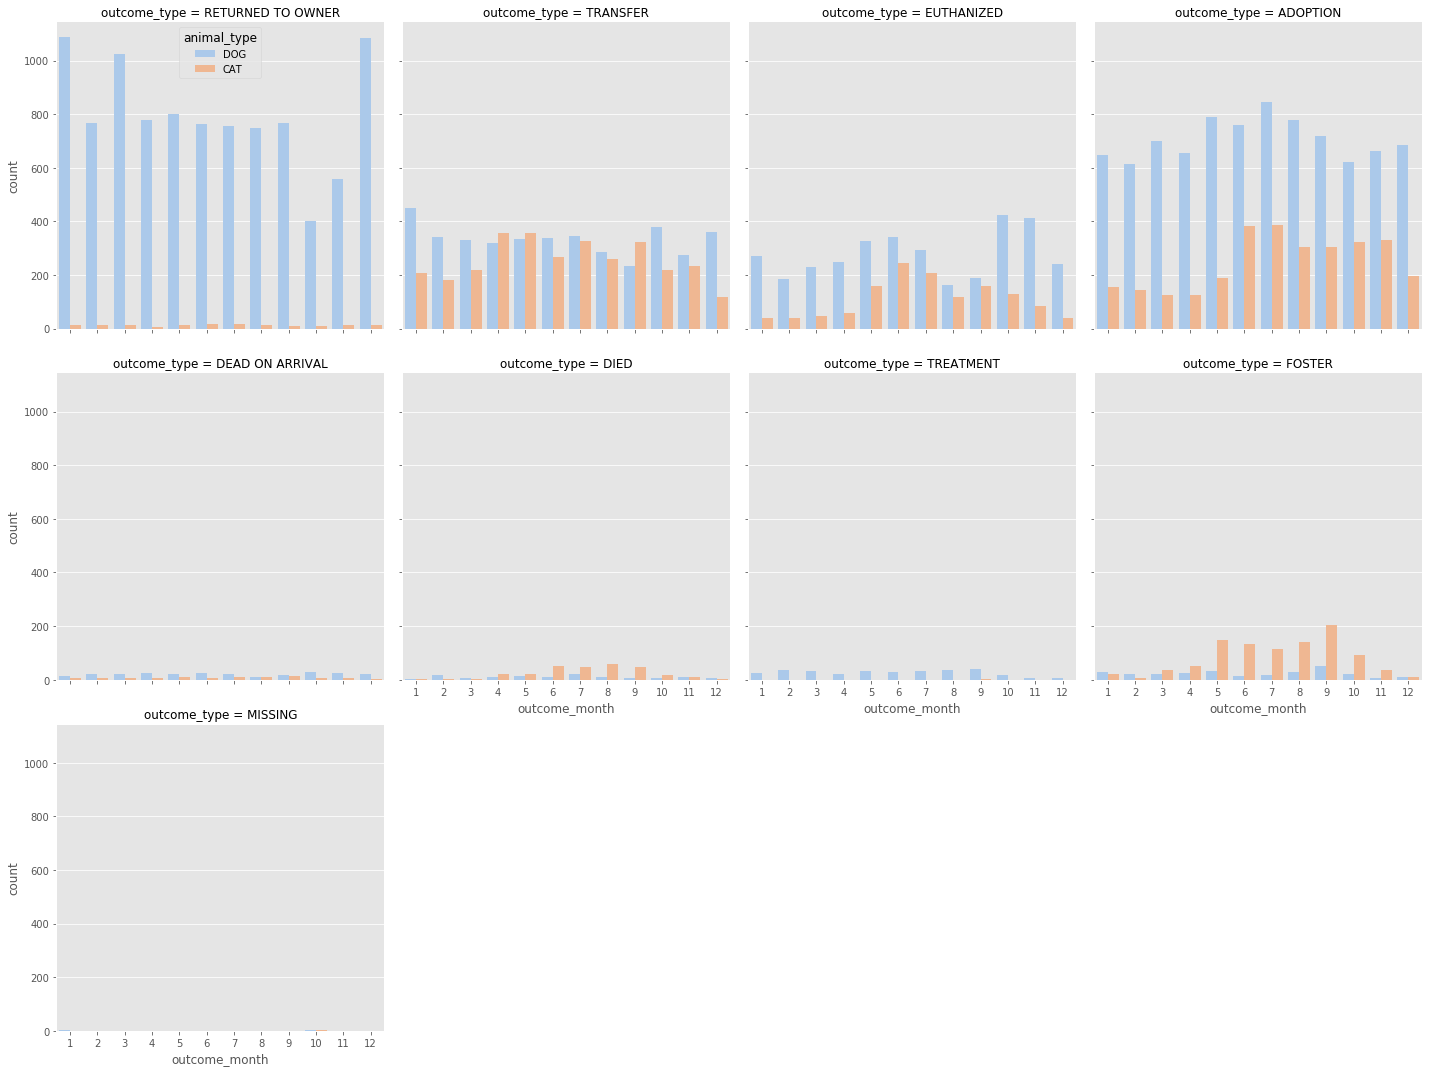

In [68]:
g = sns.catplot(x='outcome_month', col='outcome_type', hue='animal_type', col_wrap=4,
                data=dallas, kind="count", palette= 'pastel', legend_out=False)

plt.tight_layout()

plt.savefig('catplot_outcome_type_monthly.png')

## Adoption per Month

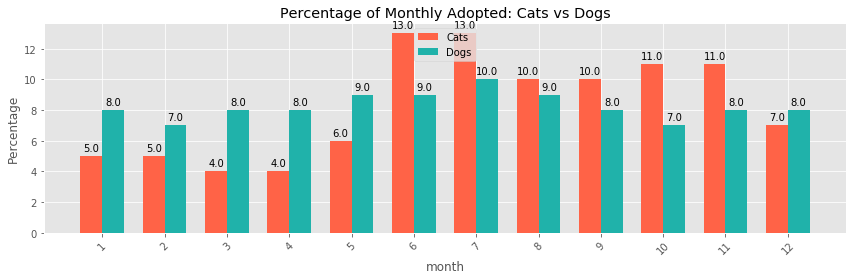

In [69]:
fig, ax = plt.subplots(figsize=(12,4))

# sns.countplot(x='month', hue='animal_type', data=dallas[dallas['outcome_type']=='ADOPTION'])

bar_percent(ax, cats[cats['outcome_type']=='ADOPTION']['outcome_month'].value_counts().sort_index(),
            dogs[dogs['outcome_type']=='ADOPTION']['outcome_month'].value_counts().sort_index())
ax.set_title('Percentage of Monthly Adopted: Cats vs Dogs')
ax.set_xlabel('month')

plt.tight_layout()
plt.savefig('bar_perc_month_adopted.png')

## Hypothesis Testing

In [70]:
val_cats = cats[cats['outcome_type'] == 'ADOPTION'].groupby('outcome_month').count()['outcome_type'].values
val_dogs = dogs[dogs['outcome_type'] == 'ADOPTION'].groupby('outcome_month').count()['outcome_type'].values

avg_cats = cats[cats['outcome_type'] == 'ADOPTION'].groupby('outcome_month').count()['outcome_type'].values.mean()
avg_dogs = dogs[dogs['outcome_type'] == 'ADOPTION'].groupby('outcome_month').count()['outcome_type'].values.mean()

std_cats = cats[cats['outcome_type'] == 'ADOPTION'].groupby('outcome_month').count()['outcome_type'].values.std()
std_dogs = dogs[dogs['outcome_type'] == 'ADOPTION'].groupby('outcome_month').count()['outcome_type'].values.std()

std_err_cats = std_cats / np.sqrt(12)
std_err_dogs = std_dogs / np.sqrt(12)

cats_dist = stats.norm(loc=avg_cats, scale=std_err_cats)
dogs_dist = stats.norm(loc=avg_dogs, scale=std_err_dogs)

In [71]:
print('average cats adopted per month: ', round(avg_cats, 2))
print('average dogs adopted per month: ', round(avg_dogs, 2))

average cats adopted per month:  247.0
average dogs adopted per month:  706.58


In [72]:
print('standard deviation cats: ', round(std_cats, 2))
print('standard deviation dogs: ', round(std_dogs, 2))

standard deviation cats:  96.11
standard deviation dogs:  70.07


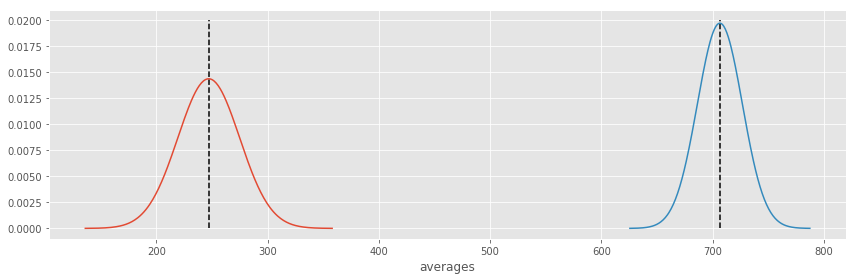

In [76]:
fig, ax = plt.subplots(figsize=(12,4))

cats_plot = np.linspace(avg_cats - 4*std_err_cats, avg_cats + 4*std_err_cats, num=250)
ax.plot(cats_plot, cats_dist.pdf(cats_plot))

dogs_plot = np.linspace(avg_dogs - 4*std_err_dogs, avg_dogs + 4*std_err_dogs, num=250)
ax.plot(dogs_plot, dogs_dist.pdf(dogs_plot))

ax.vlines(avg_cats, 0, 0.02, linestyles='--')
ax.vlines(avg_dogs, 0, 0.02, linestyles='--')
ax.set_xlabel('averages')
plt.tight_layout()

plt.savefig('pval.png')

In [74]:
stat, p_val = stats.ttest_ind(val_cats, val_dogs, equal_var=False)

print('P-value: ', p_val)

P-value:  3.889099538391116e-11


In [75]:
dallas.to_pickle('df.pkl.bz2', compression='bz2')